In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/player-segmentation/Test.mp4
/kaggle/input/player-segmentation/0_500/images/208.jpg
/kaggle/input/sam-vit/sam_vit_b_01ec64.pth
/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth
/kaggle/input/segment-anything/pytorch/vit-l/1/model.pth


In [2]:
!pip install -q imantics
!pip install -q segmentation_models_pytorch

In [3]:
import os
import random
import json

from tqdm import tqdm
import imantics
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import albumentations as A
import sys

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Extract Frames From Video File

In [ ]:
input_path = "../input/player-segmentation/"
frame_save_path = "/kaggle/working/frames"

STRIDE = 0.1
MAX_IMAGE_SIZE = 1024

In [4]:
def get_frames_from_video(video_file, stride=1.0):
    """
    video_file - path to file
    stride - i.e 1.0 - extract frame every second, 0.5 - extract every 0.5 seconds
    return: list of images, list of frame times in seconds
    """
    video = cv2.VideoCapture(video_file)
    fps = video.get(cv2.CAP_PROP_FPS)
    i = 0.
    images = []
    frame_times = []

    while video.isOpened():
        ret, frame = video.read()
        if ret:
            images.append(frame)
            frame_times.append(i)
            i += stride
            video.set(1, round(i * fps))
        else:
            video.release()
            break
    return images, frame_times


def resize_if_necessary(image, max_size=1024):
    """
    if any spatial shape of image is greater 
    than max_size, resize image such that max. spatial shape = max_size,
    otherwise return original image
    """
    if max_size is None:
        return image
    height, width = image.shape[:2]
    if max([height, width]) > max_size:
        ratio = float(max_size / max([height, width]))
        image = cv2.resize(image, (0, 0), fx=ratio, fy=ratio, interpolation=cv2.INTER_CUBIC)
    return image

In [ ]:
sample_video = '../input/player-segmentation/Test.mp4'

images, frame_times = get_frames_from_video(sample_video, STRIDE)
images = [resize_if_necessary(image, MAX_IMAGE_SIZE) for image in images]

In [ ]:
import math 
plt.figure(figsize=(50,30))
columns = 5
for i, (image, frame_time) in enumerate(zip(images, frame_times)):
    plt.subplot(math.ceil(len(images) / columns + 1), columns, i + 1).set_title("Frame time: " + str(frame_time))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


In [ ]:
mkdir /kaggle/working/frames

In [ ]:
def process_video(input_path, save_path, stride, max_image_size):

    images, frame_times = get_frames_from_video(input_path, stride)
    images = [resize_if_necessary(image, max_image_size) for image in images]
    for image, frame_time in zip(images, frame_times):
        image_name = str(round(frame_time, 3)).replace(".", "_")
        ssave_path = os.path.join(save_path, "{}.jpg".format(image_name))
        print('saving:  ', ssave_path)
        cv2.imwrite(ssave_path, image)  

process_video(sample_video, frame_save_path, STRIDE, MAX_IMAGE_SIZE)

### Recreate video from frames

In [ ]:
# importing libraries
import os
import cv2 
from PIL import Image 
  
# Video Generating function
def generate_video(input_folder = '/kaggle/working/frames', video_name = 'mygeneratedvideo.avi'):
    image_folder = '/kaggle/working/frames' # make sure to use your folder
    video_name = 'mygeneratedvideo.avi'
      
    images = [img for img in os.listdir(image_folder)
              if img.endswith(".jpg") or
                 img.endswith(".jpeg") or
                 img.endswith("png")]
     
    # Array images should only consider the image files ignoring others if any
    print(images) 
  
    frame = cv2.imread(os.path.join(image_folder, images[0]))
  
    # setting the frame width, height width
    # the width, height of first image
    height, width, layers = frame.shape  
  
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), 10, (width, height)) 
  
    # Appending the images to the video one by one
    # for image in images: 
    #     video.write(cv2.imread(os.path.join(image_folder, image))) 
    
    for sec in range(34):
        for frame in range(10):
            img = cv2.imread(f'/kaggle/working/frames/{sec}_{frame}.jpg')
            video.write(img)
      
    # Deallocating memories taken for window creation
    # cv2.destroyAllWindows() 
    video.release()  # releasing the video generated
  
  
# Calling the generate_video function
generate_video()

### Prepare data

In [26]:
N_IMAGES = 512
TRAIN_IMAGE_SIZE = 512
INPUT_IMAGE_SIZE = (1920, 1080)

In [22]:
with open("../input/player-segmentation/instances_default.json") as f:
    annotations = json.load(f)

map_id_filename = {}
for index in range(len(annotations["images"])):
    map_id_filename[annotations["images"][index]["id"]] = annotations["images"][index]["file_name"]

In [27]:
images = np.zeros((N_IMAGES, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE, 3), dtype=np.uint8)
for image_id, image_filename in map_id_filename.items():
    cur_image = cv2.imread(f"../input/player-segmentation/0_500/images/{image_filename}")
    cur_image = cv2.cvtColor(cur_image, cv2.COLOR_BGR2RGB)
    cur_image = cv2.resize(cur_image, (TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE))

    images[image_id - 1] = cur_image

In [28]:
masks = np.zeros((N_IMAGES, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE), dtype=bool)

for index in range(len(annotations["annotations"])):
    image_id = annotations["annotations"][index]["image_id"]
    segmentation = annotations["annotations"][index]["segmentation"]

    cur_mask = imantics.Polygons(segmentation).mask(*INPUT_IMAGE_SIZE).array
    cur_mask = cv2.resize(cur_mask.astype(float), (TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE)) >= 0.5

    masks[image_id - 1] = masks[image_id - 1] | cur_mask

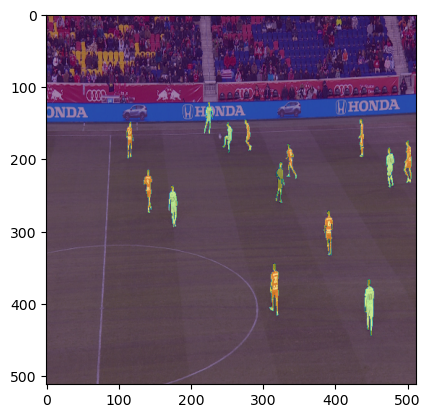

In [29]:
plt.imshow(images[100])
plt.imshow(masks[100], alpha=0.5)

In [30]:
class CFG:
    seed = 42
    train_size = 0.8
    batch_size = 4
    lr = 0.001
    n_epochs = 7
    device = "cuda"
    
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

indexes = list(range(N_IMAGES))
train_indexes = indexes[: int(N_IMAGES * CFG.train_size)]
valid_indexes = indexes[int(N_IMAGES * CFG.train_size) :]

In [31]:
def get_transforms():
    return A.Compose(
        [
            A.HueSaturationValue( # Change colors
                p=1.0, 
                hue_shift_limit=(-20, 20), 
                sat_shift_limit=(-30, 30), 
                val_shift_limit=(-20, 20),
            ),
            A.HorizontalFlip(p=0.5),
        ], 
        p=1.0
    )

In [32]:
class CustomDataset(Dataset):
    def __init__(self, indexes, transform=None, preprocess=None):
        self.indexes = indexes
        self.transform = transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, index):
        _index = self.indexes[index]

        image = images[_index]
        mask = masks[_index]
        
        if self.transform:
            data = {"image": image, "mask": mask}
            augmented = self.transform(**data)
            image, mask = augmented["image"], augmented["mask"]
        
        if self.preprocess:
            image = self.preprocess(image)
        
        image = torch.tensor(image, dtype=torch.float)
        mask = torch.tensor(mask, dtype=torch.float)

        image = image.permute(2, 0, 1)
        mask = mask.unsqueeze(0)

        return {"image": image, "mask": mask}

### Unet

In [33]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

In [34]:
preprocess_input = get_preprocessing_fn("resnet34", pretrained="imagenet")

In [35]:
train_dataset = CustomDataset(
    train_indexes, transform=get_transforms(), preprocess=preprocess_input
)
train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)

valid_dataset = CustomDataset(valid_indexes, preprocess=preprocess_input)
valid_dataloader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False)


In [36]:
model.to(CFG.device)

criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=CFG.lr)

In [37]:
def iou(outputs, labels) -> float:
    intersection = np.sum(np.logical_and(outputs, labels), axis=(1, 2, 3))
    union = np.sum(np.logical_or(outputs, labels), axis=(1, 2, 3))
    iou = intersection / union
    return np.mean(iou)

In [38]:
train_loss_history = []
val_loss_history = []
train_iou_history = []
val_iou_history = []

for epoch in range(CFG.n_epochs):
    train_loss = 0
    train_iou = 0
    model.train()
    for i, batch in tqdm(enumerate(train_dataloader)):
        inputs = batch["image"].to(CFG.device)
        labels = batch["mask"].to(CFG.device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
        train_iou += _iou

    train_loss /= len(train_dataloader)
    train_iou /= len(train_dataloader)
    train_loss_history.append(train_loss)
    train_iou_history.append(train_iou)

    val_loss = 0
    val_iou = 0
    model.eval()
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_dataloader)):
            inputs = batch["image"].to(CFG.device)
            labels = batch["mask"].to(CFG.device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
            val_iou += _iou

    val_loss /= len(valid_dataloader)
    val_iou /= len(valid_dataloader)
    val_loss_history.append(val_loss)
    val_iou_history.append(val_iou)

    print(
        "Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Train IOU: {:.4f}, Val IOU: {:.4f}".format(
            epoch + 1, CFG.n_epochs, train_loss, val_loss, train_iou, val_iou
        )
    )

103it [00:21,  4.81it/s]
26it [00:02, 12.49it/s]


Epoch [1/7], Train Loss: 0.1762, Val Loss: 0.0368, Train IOU: 0.6081, Val IOU: 0.7268


103it [00:21,  4.74it/s]
26it [00:02, 12.57it/s]


Epoch [2/7], Train Loss: 0.0244, Val Loss: 0.0160, Train IOU: 0.7762, Val IOU: 0.8156


103it [00:21,  4.77it/s]
26it [00:02, 12.71it/s]


Epoch [3/7], Train Loss: 0.0140, Val Loss: 0.0109, Train IOU: 0.8226, Val IOU: 0.8427


103it [00:21,  4.81it/s]
26it [00:02, 11.85it/s]


Epoch [4/7], Train Loss: 0.0110, Val Loss: 0.0096, Train IOU: 0.8330, Val IOU: 0.8473


103it [00:21,  4.83it/s]
26it [00:02, 12.35it/s]


Epoch [5/7], Train Loss: 0.0091, Val Loss: 0.0077, Train IOU: 0.8508, Val IOU: 0.8710


103it [00:21,  4.77it/s]
26it [00:02, 12.67it/s]


Epoch [6/7], Train Loss: 0.0084, Val Loss: 0.0073, Train IOU: 0.8538, Val IOU: 0.8652


103it [00:21,  4.77it/s]
26it [00:02, 12.45it/s]

Epoch [7/7], Train Loss: 0.0077, Val Loss: 0.0065, Train IOU: 0.8597, Val IOU: 0.8789


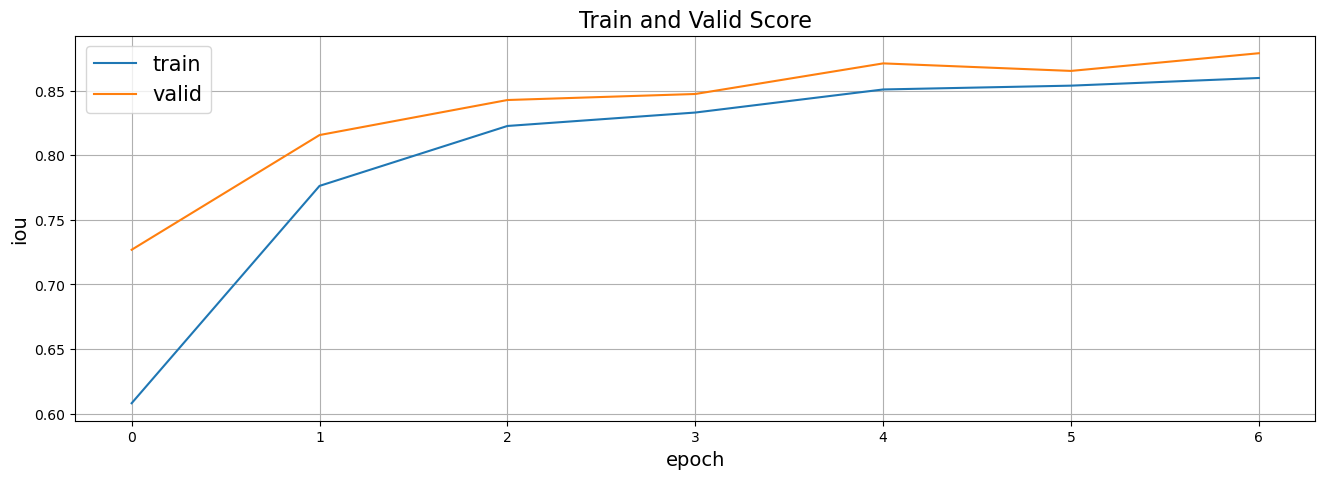

In [39]:
plt.figure(figsize=(16, 5))
plt.plot(range(CFG.n_epochs), train_iou_history, label="train")
plt.plot(range(CFG.n_epochs), val_iou_history, label="valid")

plt.title("Train and Valid Score", fontsize=16)
plt.legend(fontsize=15)
plt.ylabel("iou", fontsize=14)
plt.xlabel("epoch", fontsize=14)
plt.grid()
plt.show()

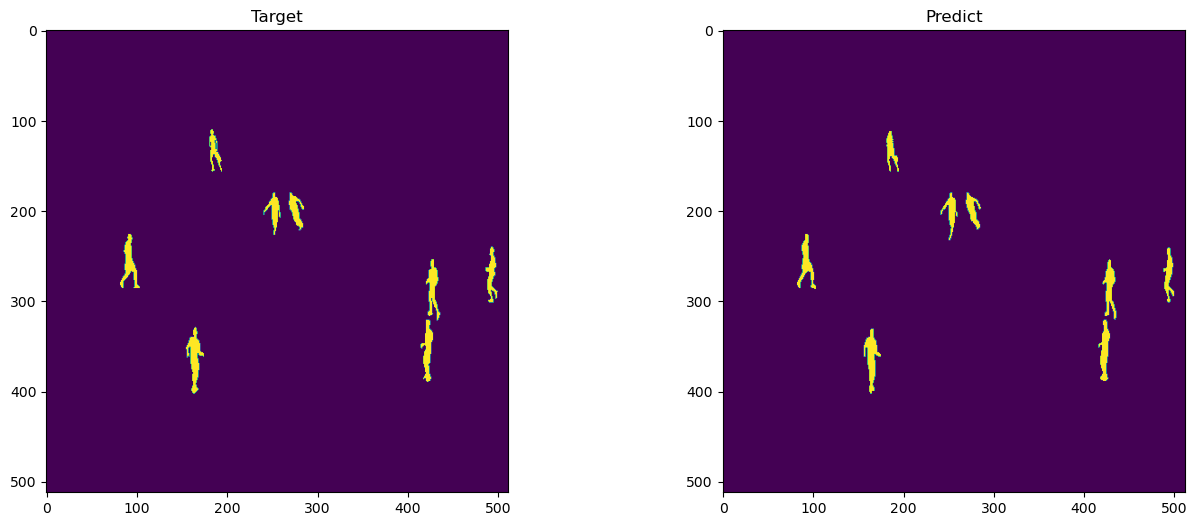

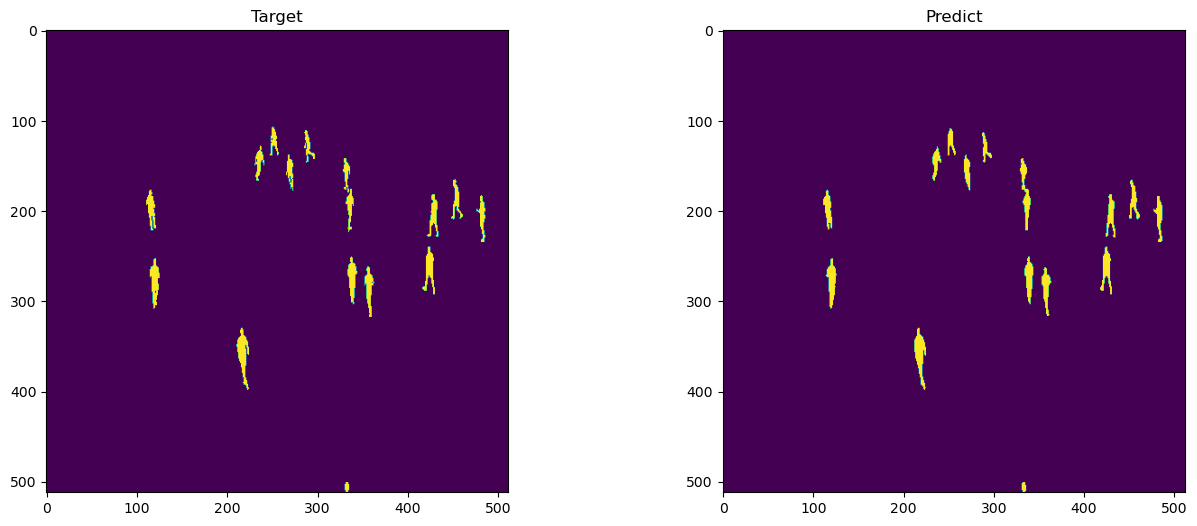

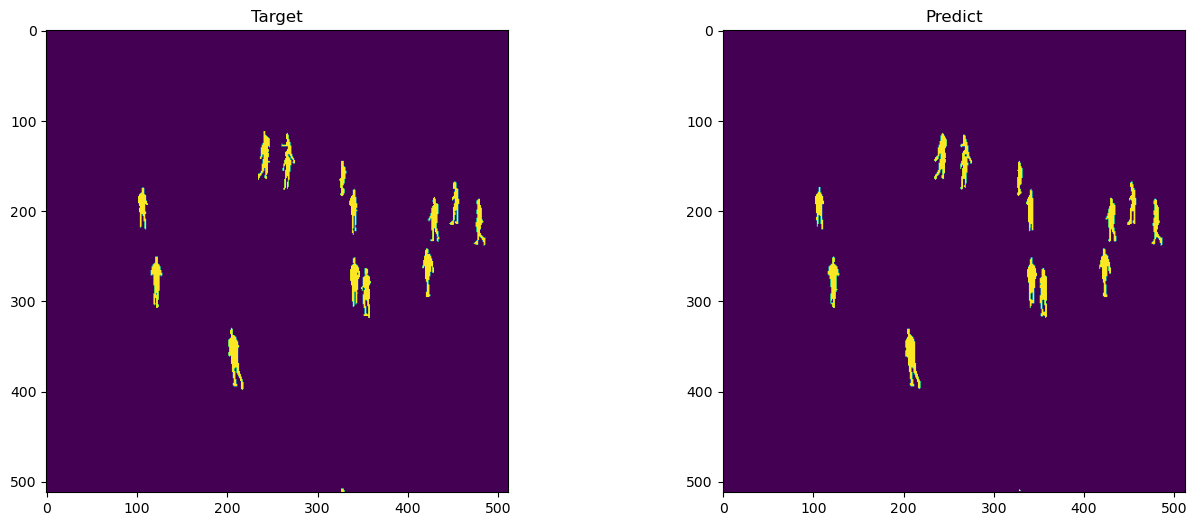

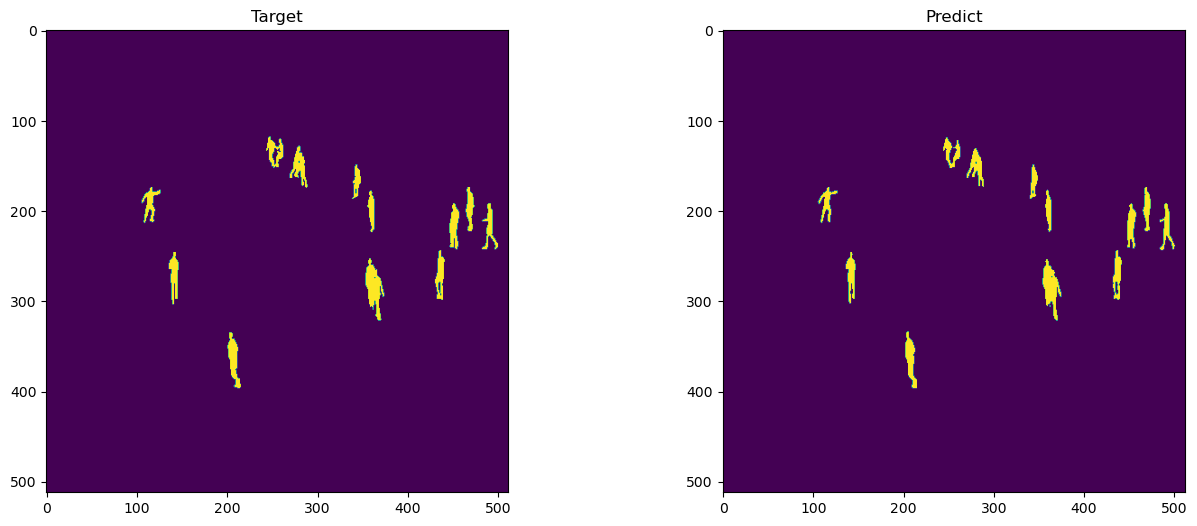

iou is 1.7680607585367172


(array([[[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]],
 
 
        [[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]],
 
 
        [[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],

In [40]:
with torch.no_grad():
    for i, batch in enumerate(valid_dataloader):
        inputs = batch["image"].to(CFG.device)
        labels = batch["mask"].to(CFG.device)

        outputs = model(inputs)

        np_labels = labels.detach().cpu().numpy()
        np_outputs = outputs.detach().cpu().numpy()

        for i in range(len(np_labels)):
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(np_labels[i][0])
            plt.title("Target")
            plt.subplot(1, 2, 2)
            plt.imshow(np_outputs[i][0] >= 0)
            plt.title("Predict")
            plt.show()
            
        _iou = iou(np_outputs >= 0, np_labels)
        val_iou += _iou
        print(f'iou is {val_iou}')
        
        break
        
np_outputs >= 0, np_labels

In [ ]:
import ipywidgets as widgets


def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.5)))
#---------------------------------------------------       
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='red', marker='o', s=80, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=80, edgecolor='white', linewidth=1.25)  
#---------------------------------------------------
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=1)
    else:
        color = np.array([200/255, 0/255, 0/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
#---------------------------------------------------   
def custom_plot(title,image,specific_point):
    input_label = np.array([1])
    #--------------
    masks = mask_generator_2.generate(image)
    
    print('masks')
    #--------------
    predictor.set_image(image)
    masks_p, scores, logits = predictor.predict(
        point_coords=specific_point,
        point_labels=input_label,
        multimask_output=True,
    )
    return masks, masks_p, scores, logits
    #--------------
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
#     #fig.suptitle(f'{title} tumor')
#     plt.axis('off')
#     ax1.imshow(image)
#     ax1.title.set_text("Image")
#     ax2.imshow(image)
#     ax2.title.set_text("Image+Masks")
#     show_anns(masks, ax2)
#     for i, (mask, score) in enumerate(zip(masks_p, scores)):
#         if i==0:
#             ax3.imshow(image)
#             ax3.title.set_text("a specific object")
#             show_points(specific_point, input_label, ax3)
#             show_mask(mask, ax4)
#             ax4.title.set_text(f"Mask - Score: {score:.3f}")
#     for ax in fig.get_axes():
#         ax.label_outer()
#         ax.axis('off')
#-----------------
def draw(img_id):    
    polygon = polygon_map[img_id]
    img = cv2.imread(img_map[img_id])

    blood_vessel = 0
    glomerulus = 0
    unsure = 0
    annotations = []
    for anno in polygon['annotations']:
        if anno['type'] == 'blood_vessel':
            color = (0,255,0)
            blood_vessel += 1
            
        elif anno['type'] == 'glomerulus':
            color = (0,0,0)
            glomerulus += 1
        else:
            color = (255,0,0)
            unsure += 1

        pts = anno['coordinates']
        pts = np.array(pts)
        pts = pts.reshape(-1, 1, 2)
        annotations.append(pts)
        cv2.polylines(img, pts, True, color, 3)
    
    print(f'{blood_vessel = }')
    print(f'{glomerulus = }')
    print(f'{unsure = }')

    plt.imshow(img)
    return annotations

#----------
def draw_sam(img_id, annotations):
    image = cv2.cvtColor(
        cv2.imread('/kaggle/input/hubmap-hacking-the-human-vasculature/train/' + img_id + '.tif'), 
        cv2.COLOR_BGR2RGB
    )
    specific_point = np.array([[50, 100]])
    #custom_plot(img_id, image, specific_point)
    (aa, a, b, c) = custom_plot(img_id, image, specific_point)
    return (aa, a, b, c)
    
output = widgets.Output()

@output.capture()
def ipydisplay(change):
    img_id = change['new']
    ipd.clear_output()
    print("Drawing....")
    annotations = draw(img_id)
    print("Finished Drawing. SAM starting...")
#     print(annotations)
    draw_sam(img_id, annotations)
    plt.axis('off')
    plt.show()
    

# you can only use this widget when actually running the notebook
# select = widgets.Dropdown(options=list(polygon_map.keys()))
# select.observe(ipydisplay, 'value')
# widgets.VBox([select, output])

In [ ]:
def draw_sam(img_id, annotations):
    image = cv2.cvtColor(
        cv2.imread('../input/player-segmentation/0_500/images/' + str(img_id) + '.jpg'), 
        cv2.COLOR_BGR2RGB
    )
    specific_point = np.array([[50, 100]])
    return custom_plot(img_id, image, specific_point)
    
(masks, masks_p, scores, logits) = draw_sam(2, None)
#masks_p, scores, logits

In [ ]:
image = cv2.cvtColor(
        cv2.imread('../input/player-segmentation/0_500/images/2.jpg'), 
        cv2.COLOR_BGR2RGB
    )
image = cv2.resize(image, (256, 256))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
plt.axis('off')
# ax1.imshow(image)
# ax1.title.set_text("Image")
ax2.imshow(image)
ax2.title.set_text("Image+Masks")
show_anns(masks, ax2)
specific_point = np.array([[50, 100]])
# for i, (mask, score) in enumerate(zip(masks_p, scores)):
#     if i==0:
#         ax3.imshow(image)
#         ax3.title.set_text("a specific object")
#         show_points(specific_point, input_label, ax3)
#         show_mask(mask, ax4)
#         ax4.title.set_text(f"Mask - Score: {score:.3f}")
for ax in fig.get_axes():
    ax.label_outer()
    ax.axis('off')